# Imports

In [1]:
import os
import math

import numpy as np

import sklearn.neighbors as nn
from scipy.interpolate import interp1d
from scipy.signal import gaussian, convolve

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, UpSampling2D, MaxPooling2D, Dropout, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

from skimage import color
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm

# Global Variables

In [2]:
# For multithreaded reading
AUTO = tf.data.experimental.AUTOTUNE

# Image dimensions
WIDTH = 64
HEIGHT = 64

NUM_TRAINING_SAMPLES = 100000
NUM_VALIDATION_SAMPLES = 1000
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
EPOCHS = 100
PATIENCE = 50
NB_NEIGHBORS = 1

CHECKPOINT_MODELS_PATH = "./models/"
DATA_DIR = "./dataset/color_data/"

KERNEL_SIZE = 4
ACTIVATION = "relu"
PADDING = "same"
STRIDE = 1
KERNEL_INIT = "he_normal"
L2_REGULARIZATION = 1e-3
DILATION_RATE = 2
NUM_CLASSES = 313

# Utils

In [30]:
# Show a single image
def visualize_image(img):
    plt.tick_params(axis='both',
                    which='both',
                    bottom=False,
                    left=False,
                    labelbottom=False,
                    labelleft=False)
    plt.imshow(img)


# Show a grid of images
def visualize_images(imgs, rows, columns, tags=None):
    f, axarr = plt.subplots(rows, columns, figsize=(20, 20))
    img_num = 0

    if rows == 1:
        for column in range(columns):
            if tags:
                axarr[column].set_title(tags[img_num])
            axarr[column].imshow(imgs[img_num])
            axarr[column].tick_params(axis='both',
                                      which='both',
                                      bottom=False,
                                      left=False,
                                      labelbottom=False,
                                      labelleft=False)
            img_num += 1

    elif columns == 1:
        for row in range(rows):
            if tags:
                axarr[column].set_title(tags[img_num])
            axarr[row].imshow(imgs[img_num])
            axarr[row].tick_params(axis='both',
                                   which='both',
                                   bottom=False,
                                   left=False,
                                   labelbottom=False,
                                   labelleft=False)
            img_num += 1

    else:
        for row in range(rows):
            for column in range(columns):
                if tags:
                    axarr[column].set_title(tags[img_num])
                axarr[row, column].imshow(imgs[img_num])
                axarr[row, column].tick_params(axis='both',
                                               which='both',
                                               bottom=False,
                                               left=False,
                                               labelbottom=False,
                                               labelleft=False)
                img_num += 1

# Color Data Generation Functions

In [2]:
# Generate all the needed files for color weights
def compute_all_color_data(dataset,
                           total_images,
                           batch_size,
                           sigma=5,
                           gamma=0.5,
                           alpha=1,
                           plot=False):
    compute_color_prior(dataset, total_images, batch_size, plot=plot)
    compute_smooth_color_prior(sigma=sigma, plot=plot)
    compute_prior_factor(gamma=gamma, alpha=alpha, plot=plot)


def compute_color_prior(dataset, total_images, batch_size, plot=False):
    # Read the buckets
    q_ab = np.load(os.path.join(DATA_DIR, "pts_in_hull.npy"))

    batches_num = total_images // batch_size

    for i, (l, ab) in enumerate(dataset.batch(batch_size).take(batches_num)):
        _compute_color_prior_batch(ab, i, q_ab, plot)

    # Read prior_prob files
    prior_prob = np.zeros((q_ab.shape[0]))
    for i in range(batches_num):
        prior_prob += np.load(
            os.path.join(DATA_DIR, "prior_prob{}.npy".format(i)))

    # Turn it into a color probability
    prior_prob = prior_prob / np.sum(prior_prob)

    # Save
    np.save(os.path.join(DATA_DIR, "prior_prob.npy"), prior_prob)

    for i in range(batches_num):
        if os.path.exists(os.path.join(DATA_DIR,
                                       "prior_prob{}.npy".format(i))):
            os.remove(os.path.join(DATA_DIR, "prior_prob{}.npy".format(i)))

    if plot:
        plt.rcParams["figure.figsize"] = (15, 10)
        plt.hist(prior_prob, bins=100)
        plt.yscale("log")
        plt.show()


# Heavily influenced by https://github.com/foamliu/Colorful-Image-Colorization
def _compute_color_prior_batch(ab, file_i, q_ab, plot):
    if plot:

        def color_func(ab):
            ab = ab.reshape(1, 1, ab.shape[0])
            col = np.concatenate((np.zeros((1, 1, 1)), ab), axis=2)
            return _lab_to_rgb(col)

        # Color array
        col_arr = np.array([color_func(clr) for clr in q_ab]).squeeze()

        # Scatter plot
        plt.figure(figsize=(15, 15))
        gs = gridspec.GridSpec(1, 1)
        ax = plt.subplot(gs[0])

        ax.scatter(q_ab[:, 0], q_ab[:, 1], 1100, col_arr, "o")
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        major_ticks = np.arange(-1.1 - 0.0355, 1.1, 0.09101)

        ax.set_xticks(major_ticks)
        ax.set_yticks(major_ticks)
        #plt.grid(c="black")
        plt.show()

    n_pts, w, h, c = ab.shape
    a = np.ravel(ab[:, :, :, 0])
    b = np.ravel(ab[:, :, :, 1])
    ab = np.vstack((a, b)).T

    if plot:
        plt.rcParams["figure.figsize"] = (15, 10)
        plt.hist2d(ab[:, 0], ab[:, 1], bins=100, density=True, norm=LogNorm())
        plt.xlim([-1, 1])
        plt.ylim([-1, 1])
        plt.colorbar()
        plt.show()
        plt.clf()
        plt.close()

    # NN on the buckets
    NN = 1
    nearest = nn.NearestNeighbors(n_neighbors=NN,
                                  algorithm="ball_tree").fit(q_ab)

    # Find nearest bucket for all pixels
    dists, ind = nearest.kneighbors(ab)

    # Count the occurances of each color
    ind = np.ravel(ind)
    counts = np.bincount(ind)
    idxs = np.nonzero(counts)[0]
    prior_prob = np.zeros((q_ab.shape[0]))
    for i in range(q_ab.shape[0]):
        prior_prob[idxs] = counts[idxs]

    # Save
    np.save(os.path.join(DATA_DIR, "prior_prob{}.npy".format(file_i)),
            prior_prob)


# Heavily influenced by https://github.com/foamliu/Colorful-Image-Colorization
def compute_smooth_color_prior(sigma=5, plot=False):
    prior_prob = np.load(os.path.join(DATA_DIR, "prior_prob.npy"))

    # Add epsilon to avoid 0 values
    prior_prob += 1e-3 * np.min(prior_prob)

    # Re-normalize
    prior_prob = prior_prob / np.sum(prior_prob)

    # Smooth with gaussian
    f = interp1d(np.arange(prior_prob.shape[0]), prior_prob)
    xx = np.linspace(0, prior_prob.shape[0] - 1, 1000)
    yy = f(xx)
    window = gaussian(2000, sigma)
    smoothed = convolve(yy, window / window.sum(), mode='same')
    fout = interp1d(xx, smoothed)
    prior_prob_smoothed = np.array(
        [fout(i) for i in range(prior_prob.shape[0])])
    prior_prob_smoothed = prior_prob_smoothed / np.sum(prior_prob_smoothed)

    # Save
    np.save(os.path.join(DATA_DIR, "prior_prob_smoothed.npy"), prior_prob)

    if plot:
        plt.rcParams["figure.figsize"] = (15, 10)
        plt.plot(prior_prob)
        plt.plot(prior_prob_smoothed, "g--")
        plt.plot(xx, smoothed, "r-")
        plt.yscale("log")
        plt.show()


# Heavily influenced by https://github.com/foamliu/Colorful-Image-Colorization
def compute_prior_factor(gamma=0.5, alpha=1, plot=False):
    prior_prob_smoothed = np.load(
        os.path.join(DATA_DIR, "prior_prob_smoothed.npy"))

    u = np.ones_like(prior_prob_smoothed)
    u = u / np.sum(u)

    prior_factor = (1 - gamma) * prior_prob_smoothed + gamma * u
    prior_factor = np.power(prior_factor, -alpha)

    # Re-normalize
    prior_factor = prior_factor / np.sum(prior_factor * prior_prob_smoothed)

    np.save(os.path.join(DATA_DIR, "prior_factor.npy"), prior_factor)

    if plot:

        def color_func(ab):
            ab = ab.reshape(1, 1, ab.shape[0])
            col = np.concatenate((np.zeros((1, 1, 1)), ab), axis=2)
            return _lab_to_rgb(col)

        # Size array
        size_arr = np.array([50 * pri_fac for pri_fac in prior_factor])

        # Color array
        col_arr = np.array([color_func(clr) for clr in q_ab]).squeeze()

        # Scatter plot
        plt.figure(figsize=(10, 10))
        gs = gridspec.GridSpec(1, 1)
        ax = plt.subplot(gs[0])

        ax.scatter(q_ab[:, 0], q_ab[:, 1], size_arr, col_arr, "o")
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])

        plt.title("Gamma:{}  Alpha:{}".format(gamma, alpha))
        plt.show()

    if plot:
        plt.figure(figsize=(10, 7))
        plt.plot(prior_factor)
        plt.yscale("log")
        plt.show()

# Training/Validation Data Generation Functions

In [9]:
q_ab = np.load(os.path.join(DATA_DIR, "pts_in_hull.npy"))
nb_q = q_ab.shape[0]
nn_finder = nn.NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(q_ab)


def _assert_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)


def _rgb_to_lab(rgb):
    lab = color.rgb2lab(rgb).astype("float32")
    return lab


def _lab_to_rgb(lab):
    lab = (lab * [50, 127.5, 127.5]) - [-50, 0.5, 0.5]
    rgb = color.lab2rgb(lab)
    return rgb


def convert_to_softmax_nb_representation(rgb):
    lab = color.rgb2lab(rgb).astype("float32")
    lab = (lab + [-50, 0.5, 0.5]) / [50, 127.5, 127.5]
    l = lab[:, :, 0]
    ab = lab[:, :, 1:]

    ab = ab.reshape((WIDTH * HEIGHT, 2))

    # Get the distance to the nearest neighbors
    dist_neighb, idx_neigh = nn_finder.kneighbors(ab)

    # format the target
    y = np.zeros((ab.shape[0], nb_q))
    idx_pts = np.arange(ab.shape[0])[:, np.newaxis]
    y[idx_pts, idx_neigh] = dist_neighb
    y = y.reshape(HEIGHT, WIDTH, nb_q)

    return l.astype("float32"), y.astype("float32")


def _split_image_to_lab(file_name):
    bits = tf.io.read_file(file_name)
    image = tf.image.decode_image(bits)
    l, ab = tf.numpy_function(convert_to_softmax_nb_representation, [image],
                              [tf.float32, tf.float32])
    file_name = tf.strings.split(file_name, sep="\\")[-1]
    return l, ab, file_name


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float32_list(list_of_floats):
    return tf.train.Feature(float_list=tf.train.FloatList(
        value=list_of_floats))


def _to_tfrecord(tfrec_filewriter, l, ab, file_name):
    feature = {
        "l": _float32_list(l.ravel()),
        "ab": _float32_list(ab.ravel()),
        "file_name": _bytes_feature(file_name),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


def _from_tfrecords(example):
    features = {
        "l": tf.io.FixedLenFeature([WIDTH * HEIGHT], tf.float32),
        "ab": tf.io.FixedLenFeature([WIDTH * HEIGHT * NUM_FEATURES],
                                    tf.float32),
        "file_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, features)

    l = tf.reshape(example['l'], shape=[WIDTH, HEIGHT, 1])
    ab = tf.reshape(example['ab'], shape=[WIDTH, HEIGHT, NUM_FEATURES])
    file_name = example['file_name']

    return l, ab


def generate_tfrecord_files(image_folder="",
                            tfrecord_folder="",
                            images_per_file=128):
    IMAGE_INPUT_PATTERN = image_folder + "*.png"
    RECORD_OUTPUT_PREFIX = tfrecord_folder
    _assert_folder_exists(tfrecord_folder)

    found_images = len(tf.io.gfile.glob(IMAGE_INPUT_PATTERN))
    print(
        "Pattern matches {} images which will be rewritten as {} TFRecord files containing ~{} images each."
        .format(found_images, math.ceil(found_images / images_per_file),
                images_per_file))

    images = tf.data.Dataset.list_files(IMAGE_INPUT_PATTERN)

    dataset = images.map(_split_image_to_lab,
                         num_parallel_calls=AUTO).batch(images_per_file)

    print("Writing TFRecords")
    for file_number, (l, ab, file_name) in enumerate(dataset):
        tfrecord_filename = RECORD_OUTPUT_PREFIX + "{:02d}-{}.tfrecord".format(
            file_number, images_per_file)

        images_in_this_file = l.numpy().shape[0]
        if not os.path.isfile(tfrecord_filename):
            with tf.io.TFRecordWriter(tfrecord_filename) as out_file:
                for i in range(images_in_this_file):
                    example = _to_tfrecord(out_file,
                                           np.array(l)[i],
                                           np.array(ab)[i],
                                           file_name.numpy()[i])
                    out_file.write(example.SerializeToString())
            print("Wrote file {} containing {} records.".format(
                tfrecord_filename, images_in_this_file))
        else:
            print("File {} already exists, skipping.".format(
                tfrecord_filename, images_in_this_file))
    return dataset.unbatch()


def read_tfrecord_files(tfrecord_folder=""):
    RECORD_OUTPUT_PREFIX = tfrecord_folder

    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    filenames_tf = tf.io.gfile.glob(RECORD_OUTPUT_PREFIX + "*.tfrecord")
    dataset = tf.data.TFRecordDataset(filenames_tf, num_parallel_reads=AUTO)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(_from_tfrecords, num_parallel_calls=AUTO)
    return dataset

# Generate TFRecord Files

In [ ]:
dataset_img_training = generate_tfrecord_files(
    image_folder="./dataset/training/",
    tfrecord_folder="./dataset/tfrecords/training/")
dataset_img_validation = generate_tfrecord_files(
    image_folder="./dataset/validation/",
    tfrecord_folder="./dataset/tfrecords/validation/")

# Read TFRecord Files

In [10]:
NUM_FEATURES = 313
dataset_training = read_tfrecord_files(
    tfrecord_folder="./dataset/tfrecords/training/")
dataset_validation = read_tfrecord_files(
    tfrecord_folder="./dataset/tfrecords/validation/")

# Generate Color Data Files

In [ ]:
compute_all_color_data(dataset_training, NUM_TRAINING_SAMPLES, 10000)

# Network Model

In [11]:
prior_factor = np.load(os.path.join(DATA_DIR, "prior_factor.npy"))
prior_factor = prior_factor.astype(np.float32)


def categorical_crossentropy_color(y_true, y_pred):
    y_true = K.reshape(y_true, (-1, NUM_CLASSES))
    y_pred = K.reshape(y_pred, (-1, NUM_CLASSES))

    idx_max = K.argmax(y_true, axis=1)

    weights = K.gather(prior_factor, idx_max)

    weights = K.reshape(weights, (-1, 1))

    y_true = y_true * weights

    cross_ent = K.categorical_crossentropy(y_true, y_pred)

    cross_ent = K.mean(cross_ent, axis=-1)

    return cross_ent


def build_model_UNET(verbose=False):
    inputs = Input((WIDTH, HEIGHT, 1))
    conv1 = Conv2D(32,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(inputs)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), name='pool_1')(conv1)
    pool1 = BatchNormalization()(pool1)

    conv2 = Conv2D(64,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='pool_2')(conv2)
    pool2 = BatchNormalization()(pool2)

    conv3 = Conv2D(128,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='pool_3')(conv3)
    pool3 = BatchNormalization()(pool3)

    conv4 = Conv2D(256,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(256,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(conv4)
    conv4 = BatchNormalization()(conv4)

    up7 = keras.layers.concatenate([UpSampling2D(size=(2, 2))(conv4), conv3])

    conv7 = Conv2D(128,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(up7)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(128,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = keras.layers.concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(64,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(up8)
    conv8 = Dropout(0.2)(conv8)
    conv8 = Conv2D(64,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = keras.layers.concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(32,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(up9)
    conv9 = Dropout(0.2)(conv9)
    conv9 = Conv2D(32,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(2, 1, 1, activation='tanh', name='tanh',
                    use_bias=False)(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    if verbose:
        model.summary()

    return model


def build_model_UNET_313(verbose=False):
    inputs = Input((WIDTH, HEIGHT, 1))
    conv1 = Conv2D(32,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(inputs)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), name='pool_1')(conv1)
    pool1 = BatchNormalization()(pool1)

    conv2 = Conv2D(64,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='pool_2')(conv2)
    pool2 = BatchNormalization()(pool2)

    conv3 = Conv2D(128,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='pool_3')(conv3)
    pool3 = BatchNormalization()(pool3)

    conv4 = Conv2D(256,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(256,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(conv4)
    conv4 = BatchNormalization()(conv4)

    up7 = keras.layers.concatenate([UpSampling2D(size=(2, 2))(conv4), conv3])

    conv7 = Conv2D(128,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(up7)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(128,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = keras.layers.concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Conv2D(64,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(up8)
    conv8 = Dropout(0.2)(conv8)
    conv8 = Conv2D(64,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = keras.layers.concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(32,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(up9)
    conv9 = Conv2D(32,
                   KERNEL_SIZE,
                   STRIDE,
                   activation='elu',
                   padding='same',
                   kernel_initializer=KERNEL_INIT)(conv9)

    conv10 = Conv2D(313, 1, 1, activation='softmax', name='softmax')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    if verbose:
        model.summary()

    return model

# Compile Model

In [14]:
model = build_model_UNET_313(verbose=True)

adam = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=adam, loss=categorical_crossentropy_color)
#model.compile(optimizer=adam, loss="mse")

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 64, 64, 32)   544         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 64, 64, 32)   0           conv2d_14[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 64, 64, 32)   16416       dropout_7[0][0]                  
____________________________________________________________________________________________

In [13]:
NUM_TRAINING_SAMPLES = 33152
NUM_VALIDATION_SAMPLES = 640
BATCH_SIZE = 64
#dataset_training = dataset_training.take(NUM_TRAINING_SAMPLES)

In [ ]:
_assert_folder_exists(CHECKPOINT_MODELS_PATH)

model_names = CHECKPOINT_MODELS_PATH + "model.{epoch:02d}-{loss:.4f}.hdf5"
callbacks = [
    ReduceLROnPlateau(monitor='val_loss',
                      factor=0.8,
                      patience=10,
                      cooldown=0,
                      verbose=1,
                      min_lr=1e-9),
    ModelCheckpoint(
        model_names,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        save_weights_only=True,
        mode='auto',
        save_freq='epoch',
    )
]
model.fit(dataset_training.batch(BATCH_SIZE).repeat(),
          steps_per_epoch=NUM_TRAINING_SAMPLES // BATCH_SIZE,
          validation_data=dataset_validation.batch(BATCH_SIZE).repeat(),
          validation_steps=NUM_VALIDATION_SAMPLES // BATCH_SIZE,
          callbacks=callbacks,
          epochs=1000)

# Display Predictions

In [ ]:
for l, ab in dataset_validation.batch(1).take(10):
    grey_img = _lab_to_rgb(np.concatenate((l[0], np.zeros((64, 64, 2))), axis=2))
    pred_img = _lab_to_rgb(np.concatenate((l[0], model.predict(l)[0]), axis=2))
    true_img = _lab_to_rgb(np.concatenate((l[0], ab[0]), axis=2))
    imgs = [grey_img, pred_img, true_img]
    visualize_images(imgs, 1, 3)

In [ ]:
for l, ab in dataset_training.batch(1).take(10):
    grey_img = _lab_to_rgb(np.concatenate((l[0], np.zeros((64, 64, 2))), axis=2))
    pred_img = _lab_to_rgb(np.concatenate((l[0], model.predict(l)[0]), axis=2))
    true_img = _lab_to_rgb(np.concatenate((l[0], ab[0]), axis=2))
    imgs = [grey_img, pred_img, true_img]
    visualize_images(imgs, 1, 3)

# Display Predictions Buckets

In [ ]:
q_ab = np.load(os.path.join(DATA_DIR, "pts_in_hull.npy"))
nb_q = q_ab.shape[0]

for i, (l, ab) in enumerate(dataset_validation.batch(1).take(140)):
    if i > 120:
        #grey_img = _lab_to_rgb(np.concatenate((l[0], np.zeros((64, 64, 2))), axis=2))

        true_bucket_ind = np.argmax(ab[0], axis=2)
        true_img = np.zeros((64, 64, 2))
        for i, row in enumerate(true_bucket_ind):
            for j, column in enumerate(true_bucket_ind[i]):
                true_img[i, j] = q_ab[column]

        true_img = _lab_to_rgb(np.concatenate((l[0], true_img), axis=2))

        X_colorized = model.predict(l)
        X_colorized = X_colorized.reshape((WIDTH * HEIGHT, nb_q))

        # Reweight probas
        X_colorized = np.exp(np.log(X_colorized + 1e-8) / 0.3)
        newshape = list(X_colorized.shape)
        newshape[-1] = 1
        X_colorized /= np.sum(X_colorized, axis=-1).reshape(newshape)

        X_colorized = np.dot(X_colorized, q_ab)
        X_ab = X_colorized.reshape((WIDTH, HEIGHT, 2))

        pred_img = np.zeros((HEIGHT, WIDTH, 3))
        pred_img[:, :, 0] = l[0].numpy().squeeze()
        pred_img[:, :, 1:3] = X_ab
        pred_img = _lab_to_rgb(pred_img)

        visualize_images([pred_img, true_img], 1, 2)

# Predict Image

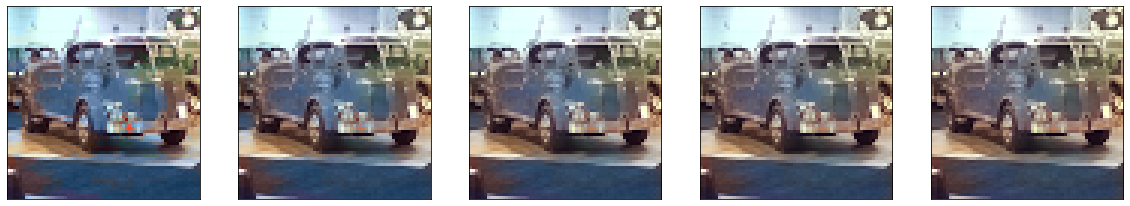

In [82]:
if True:
    img = Image.open("./test/bimp.jpg")
    im = img.resize((64, 64), Image.ANTIALIAS)
    lab = _rgb_to_lab(np.array(im)[:, :, 0:3])
else:
    lab = _rgb_to_lab(np.array(im))
lab = (lab + [-50, 0.5, 0.5]) / [50, 127.5, 127.5]
l = lab[:, :, 0].reshape((1, 64, 64, 1))
ab = lab[:, :, 1:3]
X_colorized = model.predict(l)
X_colorized = X_colorized.reshape((WIDTH * HEIGHT, nb_q))

def reweight(X_colorized, T):
    # Reweight probas
    X_colorized = np.exp(np.log(X_colorized + 1e-8) / T)
    newshape = list(X_colorized.shape)
    newshape[-1] = 1
    X_colorized /= np.sum(X_colorized, axis=-1).reshape(newshape)

    X_colorized = np.dot(X_colorized, q_ab)
    X_ab = X_colorized.reshape((WIDTH, HEIGHT, 2))

    pred_img = np.zeros((HEIGHT, WIDTH, 3))
    pred_img[:, :, 0] = l[0].squeeze()
    pred_img[:, :, 1:3] = X_ab
    pred_img = _lab_to_rgb(pred_img)
    return pred_img

Tlist = np.arange(0.05, 1, 1/5)
imgs = [reweight(X_colorized, T) for T in Tlist]
tags = ["T={}".format(round(T, 2)) for T in Tlist]
visualize_images(imgs, 1, 5)

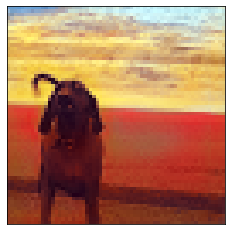

In [117]:
if True:
    img = Image.open("./test/00431.png")
    width, height = im.size
    im = img.resize((64, 64), Image.ANTIALIAS)
    lab = _rgb_to_lab(np.array(im)[:, :, 0:3])
else:
    lab = _rgb_to_lab(np.array(im))
    
lab = (lab + [-50, 0.5, 0.5]) / [50, 127.5, 127.5]
l = lab[:, :, 0].reshape((1, 64, 64, 1))
ab = lab[:, :, 1:3]
X_colorized = model.predict(l)
X_colorized = X_colorized.reshape((WIDTH * HEIGHT, nb_q))


# Reweight probas
X_colorized = np.exp(np.log(X_colorized + 1e-8) / 0.4)
newshape = list(X_colorized.shape)
newshape[-1] = 1
X_colorized /= np.sum(X_colorized, axis=-1).reshape(newshape)

X_colorized = np.dot(X_colorized, q_ab)
X_ab = X_colorized.reshape((WIDTH, HEIGHT, 2))

pred_img = np.zeros((HEIGHT, WIDTH, 3))
pred_img[:, :, 0] = l[0].squeeze()
pred_img[:, :, 1:3] = X_ab
pred_img = _lab_to_rgb(pred_img)
grey_img = _lab_to_rgb(np.concatenate((l[0], np.zeros((64, 64, 2))), axis=2))
visualize_image(pred_img)